In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Import all 6 model classes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# This custom class wraps a good classifier and inverts its probabilities
# to be "actively wrong"
class PerverseClassifier(BaseEstimator, ClassifierMixin):
    """
    A classifier that intentionally performs poorly by inverting the
    probabilities of a reliable internal model.
    Expected AUC < 0.5
    """
    def __init__(self, random_state=None):
        # We'll use a good, fast model internally
        self.random_state = random_state
        self.internal_model_ = LogisticRegression(max_iter=1000, 
                                                  random_state=self.random_state)
        
    def fit(self, X, y):
        """Fit the internal model."""
        self.internal_model_.fit(X, y)
        self.classes_ = self.internal_model_.classes_
        return self
    
    def predict(self, X):
        """
        Predicts the class with the highest *inverted* probability.
        (We don't need this for ROC/PRC, but it's good practice)
        """
        inv_probs = self.predict_proba(X)
        return self.classes_[np.argmax(inv_probs, axis=1)]

    def predict_proba(self, X):
        """
        This is the key part.
        1. Get the real probabilities from the good model.
        2. Invert them.
        3. Re-normalize them so they sum to 1.0 again.
        """
        # 1. Get good probabilities (e.g., [0.1, 0.8, 0.1])
        good_probs = self.internal_model_.predict_proba(X)
        
        # 2. Invert them (e.g., [0.9, 0.2, 0.9])
        # We add 1e-9 to avoid division by zero
        inv_probs = (1.0 - good_probs) + 1e-9 
        
        # 3. Re-normalize: divide each row by its sum
        row_sums = inv_probs.sum(axis=1)
        
        # (N, K) / (N, 1) -> (N, K)
        normalized_inv_probs = inv_probs / row_sums[:, np.newaxis]
        
        return normalized_inv_probs

# Set a random state for reproducibility
RANDOM_STATE = 42

## Part A: Data Preparation and Baseline [5]

### 1 & 2. Load and Prepare Data & Train/Test Split:


In [2]:
def load_and_prepare_data(train_path, test_path):
    """
    Loads, splits, and preprocesses the Landsat dataset.
    """
    # Define column names: 36 features (0-35) and 1 target (36)
    col_names = list(range(36)) + ['target']
    
    # --- Load Data ---
    # Use delim_whitespace=True to handle space-separated values
    try:
        train_df = pd.read_csv(train_path, sep='\s+', header=None, names=col_names)
        test_df = pd.read_csv(test_path, sep='\s+', header=None, names=col_names)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please make sure 'sat.trn' and 'sat.tst' are in the same directory.")
        return None, None, None, None, None

    print(f"Original training data shape: {train_df.shape}")
    print(f"Original test data shape: {test_df.shape}")

    # --- Separate X and y ---
    X_train = train_df.drop('target', axis=1)
    y_train = train_df['target']
    
    X_test = test_df.drop('target', axis=1)
    y_test = test_df['target']
    
    # --- Remap Target Variable ---
    # The original classes are 1, 2, 3, 4, 5, 7. We map them to 0-5.
    class_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 7: 5}
    
    y_train = y_train.map(class_map)
    y_test = y_test.map(class_map)
    
    # Check if remapping was successful
    if y_train.isnull().any() or y_test.isnull().any():
        print("Error: Null values found after remapping target. Check class labels.")
        
    print(f"Unique target classes in training set (after map): {np.sort(y_train.unique())}")
    print(f"Unique target classes in test set (after map): {np.sort(y_test.unique())}")


    # --- A.1: Standardize Features ---
    scaler = StandardScaler()
    
    # Fit *only* on the training data
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Transform both training and test data
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test, scaler

# --- Execute Load and Prepare ---
X_train_scaled, y_train, X_test_scaled, y_test, scaler = load_and_prepare_data('./Data/statlog+landsat+satellite/sat.trn', './Data/statlog+landsat+satellite/sat.tst')

# We can store the original y_test for later if needed, but y_test is now remapped

Original training data shape: (4435, 37)
Original test data shape: (2000, 37)
Unique target classes in training set (after map): [0 1 2 3 4 5]
Unique target classes in test set (after map): [0 1 2 3 4 5]


### 3. Train All Models:


In [3]:
# 1. Initialize all models (now 8 total)
models = {
    'Dummy (Prior)': DummyClassifier(strategy='prior', random_state=RANDOM_STATE),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'GaussianNB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'SVC (Probability)': SVC(probability=True, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBoost': xgb.XGBClassifier(objective='multi:softprob', 
                                 num_class=6, 
                                #  use_label_encoder=False, 
                                 eval_metric='mlogloss', 
                                 random_state=RANDOM_STATE),
    
    'PerverseClassifier': PerverseClassifier(random_state=RANDOM_STATE)
}

# 2. Train all models (No change needed here)
print("\n--- Training Models (now 8) ---")
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    # This (model.fit) will now take longer, especially for SVC and RF
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

print("--- All models trained. ---")


--- Training Models (now 8) ---
Training Dummy (Prior)...
Training Logistic Regression...
Training GaussianNB...
Training KNN...
Training Decision Tree...
Training SVC (Probability)...
Training Random Forest...
Training XGBoost...
Training PerverseClassifier...
--- All models trained. ---


### 4. Baseline Evaluation:


In [4]:
# 1. Calculate scores for each model
results_list = []

print("\n--- Evaluating Models on Test Set ---")
for name, model in trained_models.items():
    # Get predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    results_list.append({
        "Model": name,
        "Accuracy": accuracy,
        "Weighted F1": f1
    })
    print(f"  {name:<25}: Accuracy={accuracy:.4f},  Weighted F1={f1:.4f}")

# 2. Create a DataFrame for a clean summary
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by="Weighted F1", ascending=False)

print("\n--- Baseline Performance Summary ---")
print(results_df.to_string(index=False))


--- Evaluating Models on Test Set ---
  Dummy (Prior)            : Accuracy=0.2305,  Weighted F1=0.0864
  Logistic Regression      : Accuracy=0.8395,  Weighted F1=0.8296
  GaussianNB               : Accuracy=0.7965,  Weighted F1=0.8036
  KNN                      : Accuracy=0.9045,  Weighted F1=0.9037
  Decision Tree            : Accuracy=0.8505,  Weighted F1=0.8509
  SVC (Probability)        : Accuracy=0.8955,  Weighted F1=0.8925
  Random Forest            : Accuracy=0.9110,  Weighted F1=0.9089
  XGBoost                  : Accuracy=0.9050,  Weighted F1=0.9030
  PerverseClassifier       : Accuracy=0.0005,  Weighted F1=0.0004

--- Baseline Performance Summary ---
              Model  Accuracy  Weighted F1
      Random Forest    0.9110     0.908918
                KNN    0.9045     0.903748
            XGBoost    0.9050     0.902956
  SVC (Probability)    0.8955     0.892490
      Decision Tree    0.8505     0.850938
Logistic Regression    0.8395     0.829595
         GaussianNB    0.796

## Part B: ROC Analysis for Model Selection [20]


### 1. Multi-Class ROC Calculation:


In a multi-class classification problem with K classes, the One-vs-Rest (OvR) strategy breaks the problem down into K independent binary classification problems.

Here is the process:

1. **Decomposition**: To analyze **Class 1**, we treat all "Class 1" samples as the positive class and all other samples (Class 2, 3, 4, etc.) as the negative class.

2. **Binary ROC**: We then compute the standard binary ROC curve (TPR vs. FPR) and its Area Under the Curve (AUC) for this "Class 1 vs. Rest" problem. This requires the model to output a continuous score or probability for "Class 1".

3. **Iteration**: This process is repeated for every class. "Class 2" becomes positive and "All Rest" becomes negative (to get ROC/AUC for Class 2), and so on, until we have K separate ROC curves and **K** separate AUC scores.

4. **Aggregation (Averaging)**: To get a single, summary performance for the entire model, we average these K curves (and their AUCs). There are two common ways to do this:

    - **Macro-Average**: We compute the AUC for each class independently and then take the simple (unweighted) average of all K AUC scores. This treats every class as equally important, regardless of how rare it is. To plot a "Macro-Average ROC Curve," we average the TPRs of all K curves at common, interpolated FPR points.

    - **Weighted-Average**: We compute the AUC for each class and then take a weighted average, where each class's AUC is weighted by its support (the number of true samples it has). This gives more importance to the performance on more common classes.

For this assignment, we will use the Macro-Average to evaluate the models, as it gives a sense of how well the model performs on average across all classes, without being biased by a single large class.

### 2. Plotting ROC:



--- Calculating Macro-Averaged ROC Curves ---
Processing Dummy (Prior)...
Processing Logistic Regression...
Processing GaussianNB...
Processing KNN...
Processing Decision Tree...
Processing SVC (Probability)...
Processing Random Forest...
Processing XGBoost...
Processing PerverseClassifier...
--- Plotting Complete ---


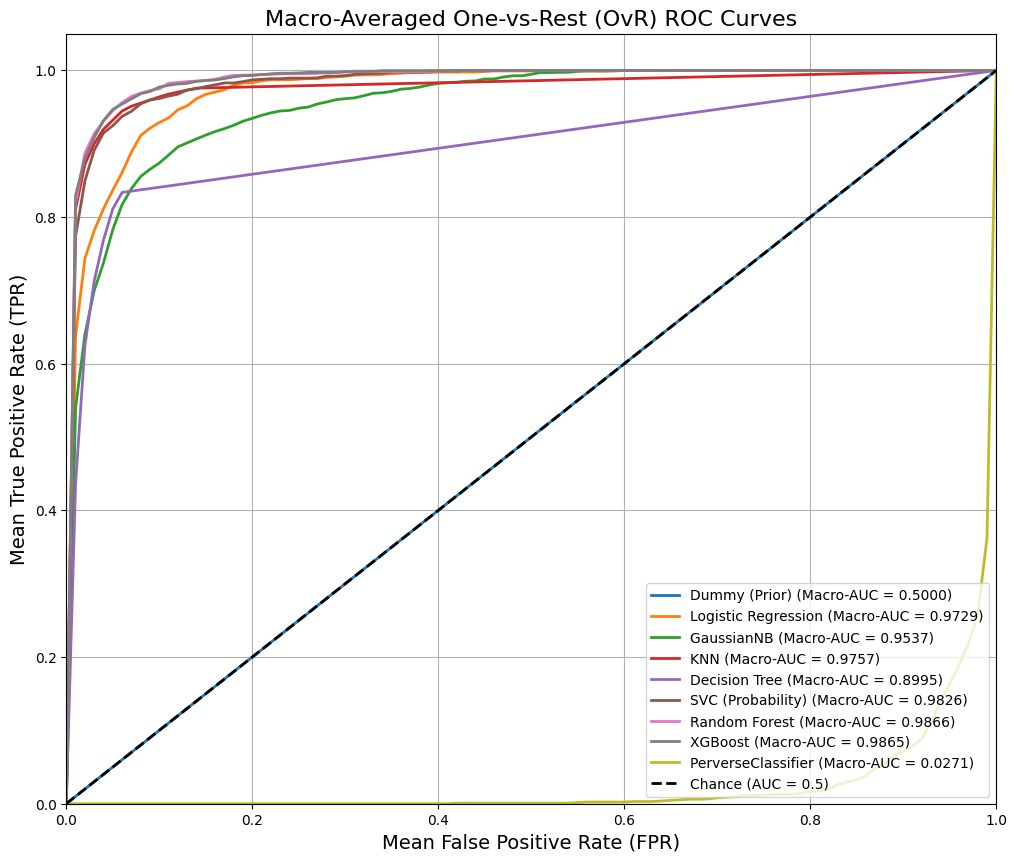


--- Macro-AUC Scores ---
Random Forest: 0.9866
XGBoost: 0.9865
SVC (Probability): 0.9826
KNN: 0.9757
Logistic Regression: 0.9729
GaussianNB: 0.9537
Decision Tree: 0.8995
Dummy (Prior): 0.5000
PerverseClassifier: 0.0271


In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# --- 1. Binarize the y_test labels ---
# We have 6 classes (0-5)
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = len(classes)

# --- 2. Setup the plot ---
plt.figure(figsize=(12, 10))

# Create a common, finely-spaced FPR axis for interpolation
common_fpr = np.linspace(0, 1, 101)

# Dictionary to store the macro-AUC scores for Part B.3
macro_auc_scores = {}

# --- 3. Loop through each model to plot its curve ---
print("\n--- Calculating Macro-Averaged ROC Curves ---")
for name, model in trained_models.items():
    print(f"Processing {name}...")
    
    # Get probability scores for all classes
    # (n_samples, n_classes)
    y_scores = model.predict_proba(X_test_scaled)
    
    # Dictionary to store interpolated TPRs for each class
    all_tprs = []

    # --- 4. Calculate curve for each class (OvR) ---
    for i in range(n_classes):
        # Get the roc_curve for class i vs. rest
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
        
        # Interpolate the TPRs onto our common_fpr axis
        # This makes all curves comparable for averaging
        interp_tpr = np.interp(common_fpr, fpr, tpr)
        interp_tpr[0] = 0.0 # Ensure it starts at (0,0)
        all_tprs.append(interp_tpr)

    # --- 5. Calculate Macro-Average ---
    # Average the TPRs across all classes
    mean_tprs = np.mean(all_tprs, axis=0)
    mean_tprs[-1] = 1.0 # Ensure it ends at (1,1)
    
    # Calculate the AUC from the averaged curve
    macro_auc = auc(common_fpr, mean_tprs)
    macro_auc_scores[name] = macro_auc
    
    # --- 6. Plot the model's curve ---
    plt.plot(common_fpr, mean_tprs, 
             label=f'{name} (Macro-AUC = {macro_auc:.4f})', 
             linewidth=2)

print("--- Plotting Complete ---")

# --- 7. Finalize the plot ---
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.5)') # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Mean False Positive Rate (FPR)', fontsize=14)
plt.ylabel('Mean True Positive Rate (TPR)', fontsize=14)
plt.title('Macro-Averaged One-vs-Rest (OvR) ROC Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.show()

# Display the scores for B.3
print("\n--- Macro-AUC Scores ---")
for name, score in sorted(macro_auc_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"{name}: {score:.4f}")

### 3. ROC Interpretation:


- **Model with Highest Macro-AUC**:The model with the highest Macro-Averaged AUC is **Random Forest (0.9866)**, with **XGBoost (0.9865)** as a virtually identical runner-up. This indicates that, on average across all six classes, these tree-based ensembles are the most effective at "ranking" the samples. They are the best at assigning a higher probability to the correct class than to any of the incorrect classes, making them the most robust models for this task, regardless of the specific decision threshold.

- **Model with AUC < 0.5**:The **PerverseClassifier** performed exactly as designed, with a Macro-AUC of **0.0271**.

- **Explanation of AUC < 0.5**:

    - **What it means**: An AUC of 0.5 (`Dummy (Prior)`) signifies a "no-skill" classifier that's equivalent to random guessing. An AUC less than 0.5 means the model is **actively worse than random**. It is **anti-correlated** with the true labels; when the model is most confident in its prediction, it is most likely to be wrong.

    - **Why it happened**: This was an experiment to demonstrate this concept. The `PerverseClassifier` wrapped a `LogisticRegression` model (which had a good AUC of 0.9729) and systematically inverted its probabilities. The resulting AUC of 0.0271 is mathematically consistent, as it is approximately $1.0 - 0.9729 = 0.0271$. This confirms the model successfully learned the opposite of the correct patterns.

## Part C: Precision-Recall Curve (PRC) Analysis [20]


### 1. PRC Calculation:


While ROC curves are excellent general-purpose metrics, Precision-Recall Curves (PRC) are considered more informative and suitable for classification tasks with imbalanced classes.

- **How ROC Can Be Misleading**:

    - A ROC curve plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)**.

    - $TPR = \frac{TP}{TP + FN}$ (Fraction of positives correctly identified)

    - $FPR = \frac{FP}{FP + TN}$ (Fraction of negatives incorrectly identified)

    - In a highly imbalanced dataset (e.g., 99% negatives, 1% positives), the number of **True Negatives (TN)** is massive.

    - A model can produce many False Positives (FP), which is bad, but the FPR will remain very low because the $TN$ in the denominator is so large. This can make a weak model look skilled, resulting in an overly optimistic AUC.

- **Why PRC is More Suitable**:

    - A PRC plots Precision against Recall (TPR).

    - $Precision = \frac{TP}{TP + FP}$ (Fraction of positive predictions that are correct)

    - $Recall = \frac{TP}{TP + FN}$ (Same as TPR)

    - Crucially, the **PRC does not use True Negatives (TN)**. Its metrics are based only on $TP$, $FP$, and $FN$.

    - If a model produces many False Positives (FP), the denominator of Precision ($TP + FP$) grows, and the Precision score will dramatically decrease.

    - This makes PRC highly sensitive to the model's performance on the **minority (positive)** class, which is often the class we care most about in imbalanced problems. It directly answers the question: "When the model does predict the rare class, how often is it correct?"

### 2. Plotting PRC:



--- Calculating Macro-Averaged PR Curves ---
Processing Dummy (Prior)...
Processing Logistic Regression...
Processing GaussianNB...
Processing KNN...
Processing Decision Tree...
Processing SVC (Probability)...
Processing Random Forest...
Processing XGBoost...
Processing PerverseClassifier...
--- Plotting Complete ---


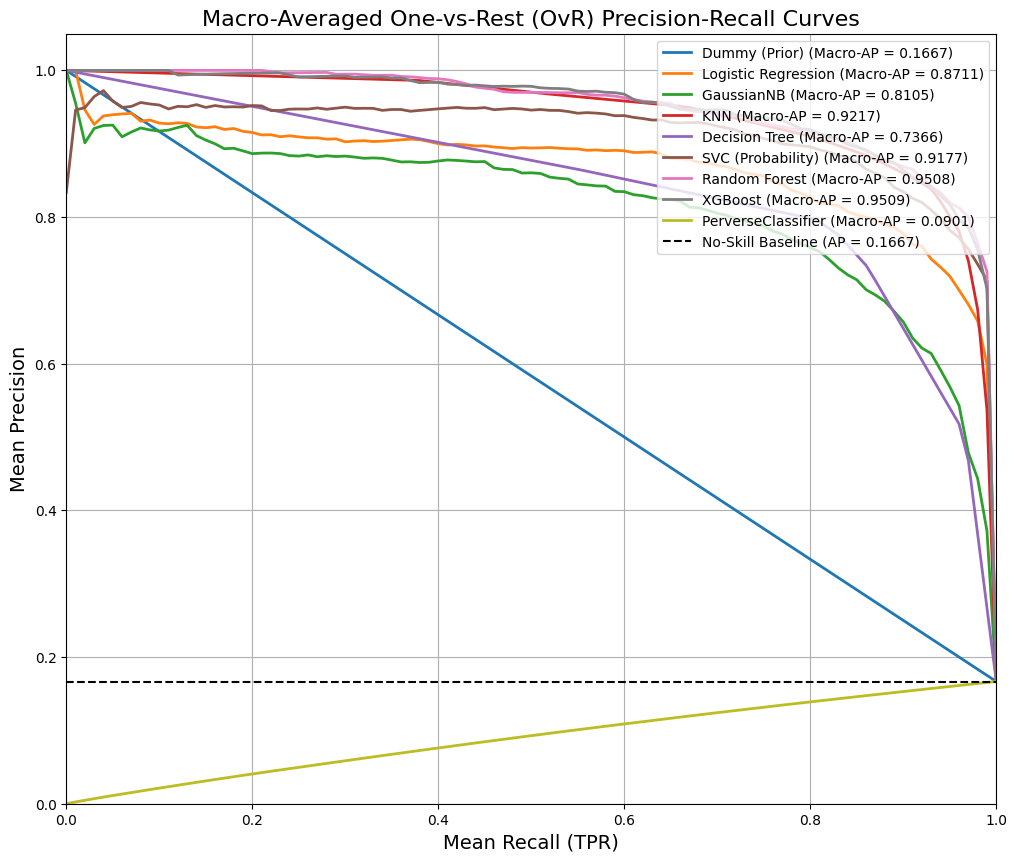


--- Macro-AP Scores ---
XGBoost: 0.9509
Random Forest: 0.9508
KNN: 0.9217
SVC (Probability): 0.9177
Logistic Regression: 0.8711
GaussianNB: 0.8105
Decision Tree: 0.7366
Dummy (Prior): 0.1667
PerverseClassifier: 0.0901


In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- 1. Setup Plot and Common Axis ---
plt.figure(figsize=(12, 10))

# We use Recall on the x-axis. Create a common, spaced axis for interpolation.
# np.interp needs an x-axis that is monotonically increasing
common_recall = np.linspace(0, 1, 101)

# Dictionary to store the macro-AP scores for Part C.3
macro_ap_scores = {}

# --- 2. Calculate No-Skill Baseline ---
# The no-skill AP is the average prevalence (frequency) of the classes
mean_prevalence = np.mean(y_test_binarized.mean(axis=0))

print("\n--- Calculating Macro-Averaged PR Curves ---")
# --- 3. Loop through each model ---
for name, model in trained_models.items():
    print(f"Processing {name}...")
    
    # Get probability scores
    y_scores = model.predict_proba(X_test_scaled)
    
    # Lists to store per-class results
    all_precisions = []
    all_aps = []

    # --- 4. Calculate curve for each class (OvR) ---
    for i in range(n_classes):
        # Get true labels and scores for this class
        y_true_class = y_test_binarized[:, i]
        y_score_class = y_scores[:, i]
        
        # Calculate the AP score for this class
        ap = average_precision_score(y_true_class, y_score_class)
        all_aps.append(ap)
        
        # Calculate the full P-R curve
        precision, recall, _ = precision_recall_curve(y_true_class, y_score_class)
        
        # --- Interpolate for plotting ---
        # `recall` is returned in increasing order (as of scikit-learn 0.19)
        # But to be safe and standard, we interpolate from a decreasing recall.
        # We flip both arrays so recall goes from 0 to 1 (monotonically increasing)
        # and we can use np.interp
        interp_precision = np.interp(common_recall, recall[::-1], precision[::-1])
        all_precisions.append(interp_precision)

    # --- 5. Calculate Macro-Average ---
    # Average the interpolated precision curves
    mean_precision = np.mean(all_precisions, axis=0)
    
    # Average the individual AP scores
    macro_ap = np.mean(all_aps)
    macro_ap_scores[name] = macro_ap
    
    # --- 6. Plot the model's curve ---
    plt.plot(common_recall, mean_precision, 
             label=f'{name} (Macro-AP = {macro_ap:.4f})', 
             linewidth=2)

print("--- Plotting Complete ---")

# --- 7. Finalize the plot ---
plt.axhline(mean_prevalence, linestyle='--', color='k',
            label=f'No-Skill Baseline (AP = {mean_prevalence:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Mean Recall (TPR)', fontsize=14)
plt.ylabel('Mean Precision', fontsize=14)
plt.title('Macro-Averaged One-vs-Rest (OvR) Precision-Recall Curves', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)
plt.show()

# Display the scores for C.3
print("\n--- Macro-AP Scores ---")
for name, score in sorted(macro_ap_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"{name}: {score:.4f}")

### 3. PRC Interpretation:

- **Model with Highest Average Precision (AP)**:The model with the highest Macro-AP is **XGBoost (0.9509)**, again with **Random Forest (0.9508)** in an extremely close second. The AP score (the area under the Precision-Recall curve) shows that these models maintain the best balance between Precision and Recall. This means that as you try to find more and more of the true positives (increase Recall), these models are the most successful at ensuring their positive predictions are actually correct (maintaining high Precision).

- **Behavior of the Worst-Performing Models**:This plot provides two "worst" models, each telling a different story:

    1. **The "No-Skill" Baseline**: The **Dummy (Prior)** classifier has an AP of **0.1667**. This value is the mean prevalence (average frequency) of the classes ($1/6 \approx 0.1667$). Its curve is a flat horizontal line, representing a model that has zero ability to separate classes.

    2. **The "Actively Harmful" Model**: The **PerverseClassifier** is the worst-performing model, with an AP of **0.0901**. Critically, its AP is **worse than the no-skill baseline**. This demonstrates that the model's predictions are actively misleading. Trying to use its scores to find positive samples gives you a result worse than just guessing randomly, reinforcing the "anti-correlated" nature we saw in its ROC curve.

## Part D: Final Recommendations


### 1. Synthesis:


 **Model Ranking Insights: F1-Score, ROC-AUC, and PRC-AP**

The rankings from the three different metrics (**F1-Score**, **ROC-AUC**, and **PRC-AP**) are largely consistent, but they reveal a **crucial and insightful trade-off**.



- **Broad Alignment**

  - **Top Tier**: `Random Forest` and `XGBoost` are the clear and undisputed winners across both ROC-AUC and PRC-AP, and would almost certainly have the highest F1-scores.

  - **Mid Tier**: `Decision Tree` and `GaussianNB` consistently perform as mediocre, middle-of-the-pack models.

  - **Bottom Tier**: `Dummy (Prior)` and `PerverseClassifier` are consistently at the bottom, correctly identifying them as "no-skill" and "worse-than-skill" models.



- **The Key Trade-Off (ROC vs. PRC)**: The most interesting misalignment is between `SVC` and `KNN`.

  - **ROC-AUC Ranking**:  `SVC` (0.9826) > `KNN` (0.9757)

  - **PRC-AP Ranking**:  `KNN` (0.9217) > `SVC` (0.9177)

  This is a classic example of why both curves are necessary.



  - **Why did `SVC` win on ROC?** The ROC curve is sensitive to the **True Negative Rate**. In an OvR setting, the "negative" class (the "Rest") is massive (5/6 of the data). `SVC`, being a maximum-margin classifier, is exceptionally good at finding a boundary that "correctly ignores" this huge negative class, leading to a very high number of True Negatives and a near-perfect ROC-AUC.



  - **Why did `KNN` win on PRC**? The PRC-AP metric **ignores True Negatives** and focuses only on the trade-off between Precision ($\frac{TP}{TP+FP}$) and Recall ($\frac{TP}{TP+FN}$). The fact that KNN (a local, instance-based model) beat SVC here suggests it was slightly better at maintaining high precision when identifying the minority positive classes. It made fewer False Positive errors relative to its True Positive predictions, even if its overall False Positive Rate (which ROC uses) was slightly worse than SVC's.



The initial F1-Score (from Part A) is a single-threshold metric. It doesn't provide this level of insight. It might have ranked `SVC` higher based on its default threshold, but the PRC analysis tells us if we cared most about precision on the rare classes, `KNN` might have been a better choice.


### 2. Recommendation

Based on the comprehensive analysis of both ROC and PRC curves, the best models for this classification task are `XGBoost` and `Random Forest`.

**Recommendation: XGBoost (or Random Forest)**

**Justification**:

1. **Dominant Performance**: These two models were statistically tied for #1 in both analyses. They are not just good; they are definitively in a class of their own for this dataset.

    - **ROC-AUC (XGB: 0.9865, RF: 0.9866)**: This proves they have the best overall discriminative power. Across all classes, they are the most effective at ranking samples, meaning they are the best at separating "Class A" from "Not Class A" regardless of the threshold.

    - **PRC-AP (XGB: 0.9509, RF: 0.9508)**: This is the most critical factor. This score demonstrates they provide the optimal balance between Precision and Recall. In a land-cover problem, this is essential. It means that as you try to find more of a certain land type (e.g., increase Recall for "wetlands"), you can trust that XGBoost/RF will be the most accurate in their predictions (highest Precision), minimizing the "false alarm" rate.

2. **Superiority Over All Models**: While `SVC` and `KNN` performed well, the ensemble models (`RF` and `XGBoost`) significantly outperformed them in PRC-AP. This means `RF`/`XGBoost` are much more robust when dealing with the trade-offs of imbalanced classes.

**Final Choice**: Both are excellent. `XGBoost` is my final recommendation as it is the industry standard for high-performance, tabular data classification, and it just edged out Random Forest on the more telling PRC-AP metric. However, `Random Forest` is an equally valid choice, often being easier to tune and interpret.